# 5.1 Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

In [4]:
df = pd.read_csv('../Dataset/cleaned_dataset.csv', encoding = "utf-8")
df.drop("Unnamed: 0",axis=1,inplace=True)

In [5]:
df.head()

,text,is_misinfo
0,My 87 year old grandmother has been quarantini...,0
1,I’m so excited that with this vaccine I can se...,0
2,So excited that I was able to close out 2020 o...,0
3,"Well, it happened. My daughter used my grandch...",1
4,"I’m getting my COVID-19 vaccine, baby! I’m so ...",0


# 5.2 Splitting Data

In [6]:
df_train, df_test = train_test_split(df, test_size=.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=df_test.shape[0]/df_train.shape[0], 
                                    random_state=42)

In [7]:
df_train.shape, df_val.shape, df_test.shape

((7725, 2), (2576, 2), (2576, 2))

In [8]:
df_train.head()

,text,is_misinfo
10183,2020 onwards is condolence period... \nHumans ...,1
4543,We postponed the start of VAX101 to this Frida...,1
6068,GOT MY SHOT \n\n#Pfizer https://t.co/DQAr1hiZoh,0
5322,i have a vaccine appointment!,0
7389,"Look if you are waiting to get your vaccine, I...",0


In [9]:
df_train['is_misinfo'].dtype

dtype('int64')

# 5.3 Tokenization for BERT

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
tokenizer('This is anti vaccine!!!')

{'input_ids': [101, 2023, 2003, 3424, 17404, 999, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
for row in df_test.itertuples():
  text = row[1]
  label = row[2]
  tokenized = tokenizer(text, 
                                  max_length=128, 
                                  padding='max_length', 
                                  truncation=True)


In [14]:
print(tokenized)

{'input_ids': [101, 2065, 2017, 2292, 2115, 18551, 15385, 2115, 2227, 2017, 2123, 2102, 2031, 2000, 4737, 2055, 2054, 2015, 1999, 1996, 17404, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
def data_gen(data):
    def g():
        for row in data.itertuples():
            text = row[1]
            label = row[2]
            tokenized = tokenizer(text, 
                                  max_length=128, 
                                  padding='max_length', 
                                  truncation=True)
            yield {k: np.array(tokenized[k]) for k in tokenized}, label
    return g

input_names = ['input_ids', 'token_type_ids', 'attention_mask']
data_types = ({k: tf.int32 for k in input_names}, tf.int64)
data_shapes = ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([]))

data_train = tf.data.Dataset.from_generator(
    data_gen(df_train),
    data_types, data_shapes
).shuffle(100).batch(32).repeat(4)

data_val = tf.data.Dataset.from_generator(
    data_gen(df_val),
    data_types, data_shapes).shuffle(100).batch(32)

In [16]:
data_train.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
model = TFBertForSequenceClassification.from_pretrained('vinai/bertweet-base') #changee to berttweet

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/705M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertForSequenceClassification: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier', 'bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
opt = optimizers.Adam(learning_rate=3e-5)
scce = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=scce, metrics='accuracy')

In [23]:
ES = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   patience=2,
                   restore_best_weights=True)

history = model.fit(data_train,  
          validation_data=data_val,
          epochs=10, 
          steps_per_epoch=64, 
          callbacks=ES)

Epoch 1/10
64/64 [==============================] - 1783s 28s/step - loss: 0.0148 - accuracy: 0.9971 - val_loss: 0.1458 - val_accuracy: 0.9689
Epoch 2/10
64/64 [==============================] - 1681s 26s/step - loss: 0.0258 - accuracy: 0.9941 - val_loss: 0.1057 - val_accuracy: 0.9732
Epoch 3/10
64/64 [==============================] - 1503s 23s/step - loss: 0.0474 - accuracy: 0.9888 - val_loss: 0.1045 - val_accuracy: 0.9709
Epoch 4/10
64/64 [==============================] - 1413s 22s/step - loss: 0.0369 - accuracy: 0.9852 - val_loss: 0.0947 - val_accuracy: 0.9790
Epoch 5/10
64/64 [==============================] - 1351s 21s/step - loss: 0.0196 - accuracy: 0.9966 - val_loss: 0.1028 - val_accuracy: 0.9748
Epoch 6/10
64/64 [==============================] - 1386s 22s/step - loss: 0.0170 - accuracy: 0.9961 - val_loss: 0.1037 - val_accuracy: 0.9732


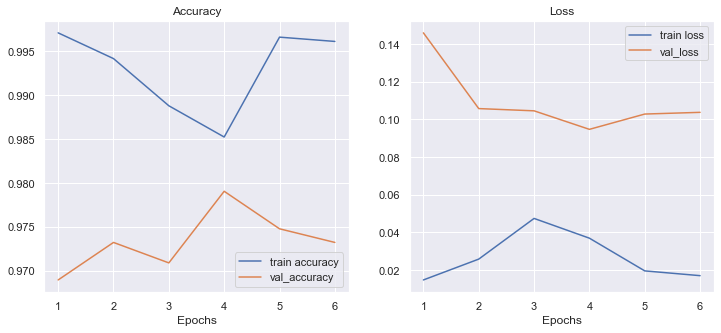

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['accuracy'], 
         label='train accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_accuracy'], 
         label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['loss'], 
         label='train loss')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_loss'], 
         label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss')
plt.show()

In [25]:
model.save_pretrained('BERT_model')

# 5.4 Evaluation

In [26]:
from scipy.special import softmax

In [27]:
data_test = tf.data.Dataset.from_generator(
    data_gen(df_test),
    data_types, data_shapes).batch(32)

In [28]:
model.evaluate(data_test)

81/81 [==============================] - 359s 4s/step - loss: 0.0918 - accuracy: 0.9763


[0.09180468320846558, 0.9763198494911194]

In [29]:
predictions = model.predict(data_test)
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[ 3.9148333, -3.2170386],
       [-3.7165072,  2.9634488],
       [ 3.6125512, -3.069159 ],
       ...,
       [-3.7181745,  2.9592593],
       [ 3.9965587, -3.2393878],
       [ 3.9721298, -3.2320695]], dtype=float32), hidden_states=None, attentions=None)

In [30]:
pred_scores = softmax(predictions[0], axis=1)[:,1]

In [31]:
pred_targets = np.where(pred_scores >= .5, 1, 0)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [34]:
print(classification_report(df_test['is_misinfo'], pred_targets))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1707
           1       0.97      0.96      0.96       869

    accuracy                           0.98      2576
   macro avg       0.97      0.97      0.97      2576
weighted avg       0.98      0.98      0.98      2576



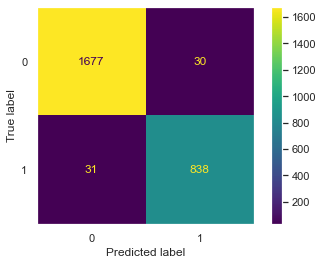

In [36]:
cm = confusion_matrix(df_test['is_misinfo'], pred_targets, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(None)
plt.show()

In [37]:
from sklearn.metrics import plot_roc_curve, roc_curve, precision_recall_curve, roc_auc_score

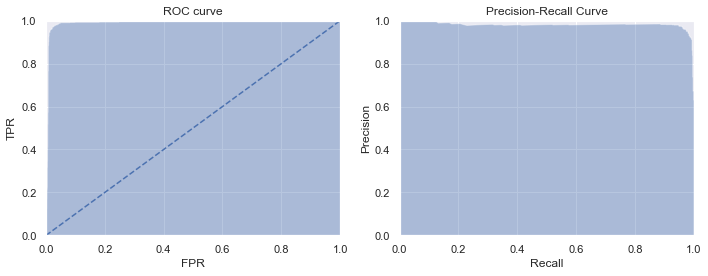

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
fpr = roc_curve(df_test['is_misinfo'], pred_scores)[0]
tpr = roc_curve(df_test['is_misinfo'], pred_scores)[1]
plt.fill_between(fpr,tpr,alpha=.4)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed')
plt.ylim(0,1)
plt.xlim(0,1)

plt.subplot(1,2,2)
prec = precision_recall_curve(df_test['is_misinfo'], pred_scores)[0]
recall = precision_recall_curve(df_test['is_misinfo'], pred_scores)[1]

plt.fill_between(recall, prec, alpha=.4)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)

plt.tight_layout()
plt.show()

# 5.5 Evaluating on new tweets

In [40]:
def make_prediction(tweet_text):
  # Can only handle one tweet at a time
  tokenized_tweet = tokenizer(tweet_text)
  logits = model.predict({k: np.array(tokenized_tweet[k])[None] for k in input_names})[0]

  scores = softmax(logits)
  if scores.flatten()[1] >= .5:
    return ('Anti-Vaccine', scores.flatten()[1])
  else:
    return ('Pro-Vaccine', scores.flatten()[1])

In [62]:
make_prediction("finally got the vaccine")


('Pro-Vaccine', 0.00065898296)

In [58]:
make_prediction("the vaccine is experimental")


('Anti-Vaccine', 0.99873644)

In [60]:
make_prediction("vaccine kill us")


('Anti-Vaccine', 0.9987632)